In [10]:
from pyomo.environ import *
import pyomo.environ as pyo
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from IPython.display import clear_output
import time
import copy
from scipy.spatial import Voronoi, voronoi_plot_2d
import gurobipy as gp
from gurobipy import GRB

In [11]:
geodata = pd.read_csv('CommunityClubsTest-clean.csv')
print(geodata)
bloodbankcoords = pd.read_csv('HSA bloodbank coordinates1.csv')
print(bloodbankcoords)
privhospcoords = pd.read_csv("Plot_of_Hospitals,_Blood_Banks_&_Community_Centers_Private_Hospital (3).csv")
pubhospcoords = pd.read_csv("Plot_of_Hospitals,_Blood_Banks_&_Community_Centers_Public_Hospital (3).csv")

            Y           X     Name
0    1.427493  103.792241    kml_1
1    1.354658  103.889546    kml_2
2    1.397128  103.886666    kml_3
3    1.366833  103.840668    kml_4
4    1.320799  103.747540    kml_5
..        ...         ...      ...
120  1.339973  103.737066  kml_121
121  1.386807  103.771521  kml_122
122  1.341263  103.933010  kml_123
123  1.311728  103.952223  kml_124
124  1.339360  103.727300  kml_125

[125 rows x 3 columns]
       Blood Bank  Postal Code  Latitude   Longitude
0             HSA       169078  1.281335  103.838482
1     Dhoby Ghaut       238826  1.299755  103.846084
2  Westgate Tower       608531  1.335374  103.743005
3       Woodlands       730900  1.436139  103.787195
4     One Punggol       828629  1.408468  103.905039


In [ ]:
# y-coordinates/latitude of CCs, BBs and hospitals
y_coordCC = geodata['Y']
y_coordBB = bloodbankcoords['Latitude']
y_coord_privhosp = privhospcoords['Latitude']
y_coord_pubhosp = pubhospcoords['Latitude']

# x-coordinates/longitude of CCs, BBs and hospitals
x_coordCC = geodata['X']
x_coordBB = bloodbankcoords['Longitude']
x_coord_privhosp = privhospcoords['Longitude']
x_coord_pubhosp = pubhospcoords['Longitude']


#no. of BBs
nbrblood = 5

#no. of CCs
nbrcomm = 125

#no. of private hosps
nbrprivh = 9

#no. of public hosps
nbrpubh = 10

#radius of earth
R = 6371


def deg_to_rad(degrees):
    return degrees*(np.pi/180)

# distance calculations between CC and BBs
distancelct=np.empty([nbrblood, nbrcomm])
for i_index in range(nbrblood):
    for j_index in range(nbrcomm):
        d_lon = deg_to_rad(x_coordBB[i_index]-x_coordCC[j_index])
        d_lat = deg_to_rad(y_coordBB[i_index]-y_coordCC[j_index])
        a = np.sin(d_lat/2)**2 +np.cos(deg_to_rad(x_coordBB[i_index])) * np.cos(deg_to_rad(x_coordCC[j_index])) * np.sin(d_lon/2)**2
        c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
        distancelct[i_index,j_index] = R*c

# print(distancelct)

# Distance calculation between BBs and private hospitals
distanceBB_priv = np.empty((nbrblood, nbrprivh))

for i_index in range(nbrblood):  # loop over blood banks
    for h_index in range(nbrprivh):  # loop over private hospitals
        d_lon = deg_to_rad(x_coordBB[i_index] - x_coord_privhosp[h_index])
        d_lat = deg_to_rad(y_coordBB[i_index] - y_coord_privhosp[h_index])
        a = np.sin(d_lat / 2) ** 2 + np.cos(deg_to_rad(y_coordBB[i_index])) * np.cos(deg_to_rad(y_coord_privhosp[h_index])) * np.sin(d_lon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distanceBB_priv[i_index, h_index] = R * c


distanceBB_pub = np.empty((nbrblood, nbrpubh))

for i_index in range(nbrblood):  # loop over blood banks
    for h_index in range(nbrpubh):  # loop over public hospitals
        d_lon = deg_to_rad(x_coordBB[i_index] - x_coord_pubhosp[h_index])
        d_lat = deg_to_rad(y_coordBB[i_index] - y_coord_pubhosp[h_index])
        a = np.sin(d_lat / 2) ** 2 + np.cos(deg_to_rad(y_coordBB[i_index])) * np.cos(deg_to_rad(y_coord_pubhosp[h_index])) * np.sin(d_lon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distanceBB_pub[i_index, h_index] = R * c

comm_coords = list(zip(x_coordCC, y_coordCC))
bank_coords = list(zip(x_coordBB, y_coordBB))
privhosp_coords = list(zip(x_coord_privhosp, y_coord_privhosp))
pubhosp_coords = list(zip(x_coord_pubhosp, y_coord_pubhosp))

q_c = pd.read_csv('community_centres_with_blood_collection.csv')['Amount of Blood Collected']
g_b = [50, 60, 70, 65, 55]                # Min blood required at each bank
q_b = [100, 120, 130, 110, 115]            # Max capacity at each bank

0       14
1      758
2      503
3      353
4      453
      ... 
120    330
121    459
122    306
123    306
124    330
Name: Amount of Blood Collected, Length: 125, dtype: int64


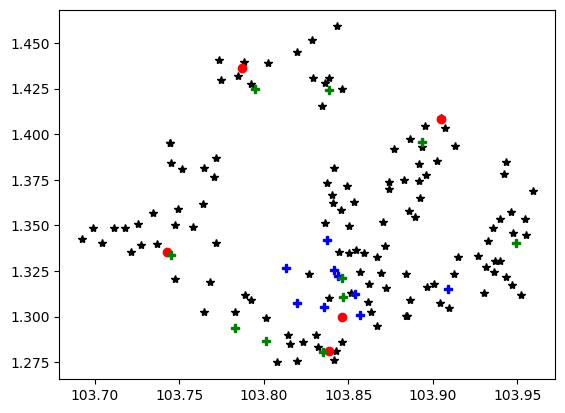

In [13]:
# 'coordlct_x' and 'coordlct_y' represent the coordinates of the facilities.
plt.plot(x_coordCC, y_coordCC, '*', color='black');
plt.plot(x_coordBB, y_coordBB, 'o', color='red');
plt.plot(x_coord_privhosp, y_coord_privhosp, 'P', color='blue')
plt.plot(x_coord_pubhosp, y_coord_pubhosp, 'P', color='green')

In [ ]:
# Initialize empty solutions to populate from each iteration of epsilon-constraint method 
optimal_costs = []
optimal_distances = []
detailed_solutions = []


#Create Model
model = gp.Model("P_Median_and_TSP")

I = list(range(nbrblood)) #Open Facilities  
J = list(range(nbrcomm)) #Facilities to be served
H_priv = list(range(nbrprivh))                          
H_pub = list(range(nbrprivh, nbrprivh + nbrpubh))        
H = H_priv + H_pub                                       

# Define variables:
x = model.addVars(I, J, vtype=GRB.BINARY, name="assign")  # If demand from location i is served by open facility j then x_ij=1 otherwise x_ij=0
y = model.addVars(I, vtype=GRB.BINARY, name="open") # Facility i to open. y_i=0 if closed and y_i=1 if open
z = model.addVars(I, H, vtype=GRB.BINARY, name="deliver") # Deliver from blood banks to hospitals

# Minimize total distance from demands to the nearest open facilities
# Each demand location j must be assigned to exactly one facility i
model.addConstrs((gp.quicksum(x[i, j] for i in I) == 1 for j in J), name="assign_once")

# The demand from location i can only be assigned to an open facility j
model.addConstrs((x[i, j] <= y[i] for i in I for j in J), name="only_open")
model.addConstr(gp.quicksum(y[i] for i in I) == nbrblood, name="open_facilities")


model.addConstr(gp.quicksum(q_c[i] * x[i, j] for i in I for j in J) >= 0.9*328, name="lower_bound_sum")
# model.addConstr(gp.quicksum(q_c[i] * x[i, j] for i in I for j in J) <= 328*2, name="upper_bound_sum")
model.addConstrs((gp.quicksum(x[i, j] for j in J) <= q_b[i] * y[i] for i in I), name="capacity_constraints")  # Capacity constraints for each bank

# Cost per km for blood collection (in SGD)
f_bc = 0.094*2.61
model.addConstr(gp.quicksum(f_bc*distancelct[i][j] * x[i, j] for i in I for j in J) <= 1000, name="budget_constraint")

# # Add constraints for blood delivery to hospitals
model.addConstrs((gp.quicksum(z[i, h] for i in I) == 1 for h in H), name="deliver_once")  # Each hospital must receive blood from exactly one bank
model.addConstrs((z[i, h] <= y[i] for i in I for h in H), name="only_open_delivery")  # Blood can only be delivered from open banks 
model.addConstrs((gp.quicksum(z[i, h] for i in I) <= q_c[h] for h in H), name="delivery_capacity")  # Capacity constraints for each hospital
# # Add constraints for maximum blood delivery to hospitals
model.addConstrs((gp.quicksum(z[i, h] for h in H) <= q_c[i] for i in I), name="max_blood_delivery")  # Maximum blood delivery to hospitals
u = model.addVars(nbrblood, nbrcomm, nbrcomm, vtype=GRB.BINARY, name="route")
for k in range(nbrblood):
    for i in range(nbrcomm):
        model.addConstr(gp.quicksum(u[k, i, j] for j in range(nbrcomm) if j != i) == x[k, i])
        model.addConstr(gp.quicksum(u[k, j, i] for j in range(nbrcomm) if j != i) == x[k, i])

# Add continuous variables for MTZ
mtz = model.addVars(nbrblood, nbrcomm, vtype=GRB.CONTINUOUS, lb=0, ub=nbrcomm, name="mtz")

for k in range(nbrblood):
    for i in range(1, nbrcomm):
        for j in range(1, nbrcomm):
            if i != j:
                model.addConstr(mtz[k, i] - mtz[k, j] + nbrcomm * u[k, i, j] <= nbrcomm - 1)

model.setObjective(
    gp.quicksum(x[i, j] * distancelct[i][j] for i in I for j in J) +
    gp.quicksum(z[i, h] * distanceBB_priv[i][h] for i in I for h in H_priv) +
    gp.quicksum(z[i, h] * distanceBB_pub[i][h - nbrprivh] for i in I for h in H_pub)+
    gp.quicksum(u[k, i, j] * np.linalg.norm(np.array(comm_coords[i]) - np.array(comm_coords[j]))
               for k in range(nbrblood) for i in range(nbrcomm) for j in range(nbrcomm) if i != j),
    GRB.MINIMIZE
)

# Optimize the model
model.optimize()

# Check if a solution was found
if model.status == gp.GRB.OPTIMAL:
    print(f"Optimal objective value: {model.objVal}")

    # Print values of decision variables
    for var in model.getVars():
        if var.X > 1e-6:  # print only non-zero values
            print(f"{var.VarName} = {var.X}")
else:
    print("No optimal solution found.")

# After model.optimize() and extracting x_vals
assignments = {i: [] for i in I}
for i in I:
    for j in J:
        if x[i, j].X > 0.5:
            assignments[i].append(j)



Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 78406 rows, 79475 columns and 389265 nonzeros
Model fingerprint: 0x1089fddb
Variable types: 625 continuous, 78850 integer (78850 binary)
Coefficient statistics:
  Matrix range     [4e-03, 8e+02]
  Objective range  [8e-04, 2e+01]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 1e+03]
Presolve removed 767 rows and 730 columns
Presolve time: 0.44s
Presolved: 77639 rows, 78745 columns, 386155 nonzeros
Variable types: 620 continuous, 78125 integer (78125 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 3.834605e+02, 907 itera

KeyboardInterrupt: 

Exception ignored in: 'gurobipy._core.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\65816\AppData\Roaming\Python\Python312\site-packages\ipykernel\iostream.py", line 655, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]

KeyboardInterrupt: 


  2480  2785  384.64537   96  161          -  383.69971      -  42.8   37s


In [ ]:
# Store the results for each iteration
optimal_costs.append(model.objVal)
optimal_distances.append(total_tsp_distance)
detailed_solutions.append({
	"objective_value": model.objVal,
	"tsp_distance": total_tsp_distance,
	"assignments": assignments.copy(),
	"tsp_distances": tsp_distances.copy()
})
# Print the detailed solutions
for i, solution in enumerate(detailed_solutions):
	print(f"Solution {i+1}:")
	print(f"  Objective Value: {solution['objective_value']}")
	print(f"  TSP Distance: {solution['tsp_distance']}")
	print("  Assignments:")
	for bank, cc_list in solution['assignments'].items():
		print(f"    Blood Bank {bank}: Assigned CCs {cc_list}")
	print("  TSP Distances:")
	for bank, tsp_dist in solution['tsp_distances'].items():
		print(f"    Blood Bank {bank}: TSP Distance {tsp_dist}")
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(x_coordCC, y_coordCC, '*', color='black', label='Community Centers')
plt.plot(x_coordBB, y_coordBB, 'o', color='red', label='Blood Banks')
plt.plot(x_coord_privhosp, y_coord_privhosp, 'P', color='blue', label='Private Hospitals')
plt.plot(x_coord_pubhosp, y_coord_pubhosp, 'P', color='green', label='Public Hospitals')			
for i in I:
	if assignments[i]:
		for j in assignments[i]:
			plt.plot([x_coordBB[i], x_coordCC[j]], [y_coordBB[i], y_coordCC[j]], 'k--', alpha=0.5)
plt.title('Blood Bank Assignments to Community Centers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()
# Display the optimal costs and distances
print("Optimal Costs:", optimal_costs)
print("Optimal Distances:", optimal_distances)
# Display the detailed solutions
for i, solution in enumerate(detailed_solutions):
	print(f"Solution {i+1}:")
	print(f"  Objective Value: {solution['objective_value']}")
	print(f"  TSP Distance: {solution['tsp_distance']}")
	print("  Assignments:")
	for bank, cc_list in solution['assignments'].items():
		print(f"    Blood Bank {bank}: Assigned CCs {cc_list}")
	print("  TSP Distances:")
	for bank, tsp_dist in solution['tsp_distances'].items():
		print(f"    Blood Bank {bank}: TSP Distance {tsp_dist}")
		

NameError: name 'optimal_costs' is not defined

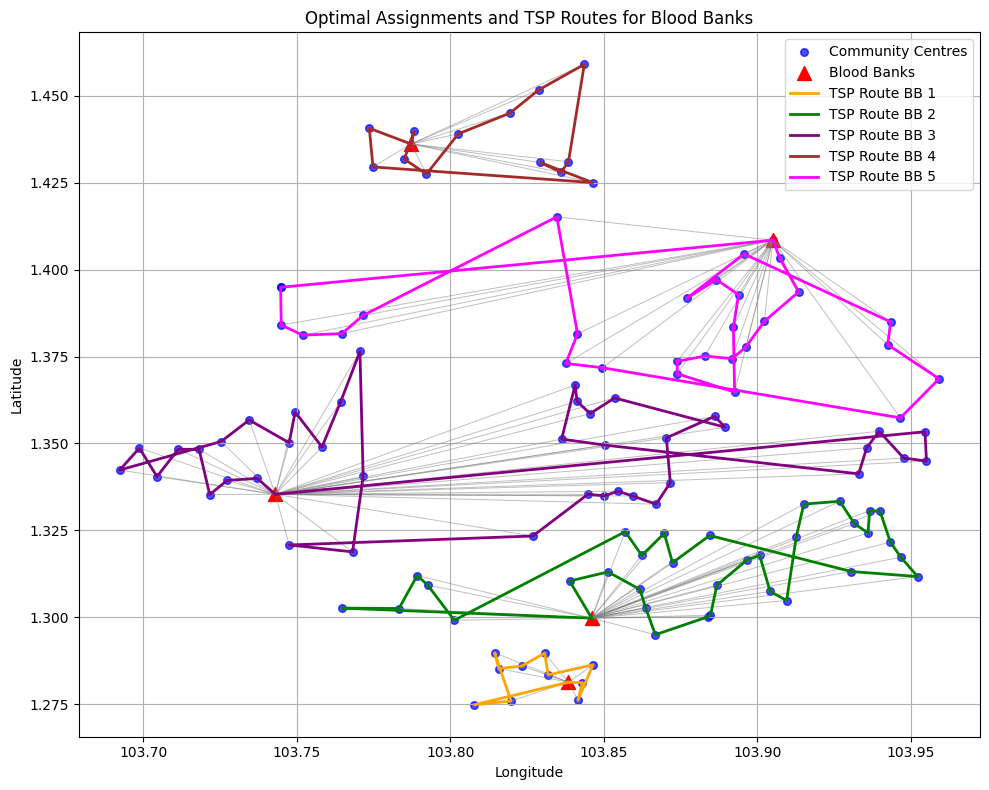

In [ ]:
plt.figure(figsize=(10, 8))

# Plot all community centres and blood banks
plt.scatter([c[0] for c in comm_coords], [c[1] for c in comm_coords], c='blue', label='Community Centres', s=30, alpha=0.7)
plt.scatter([b[0] for b in bank_coords], [b[1] for b in bank_coords], c='red', label='Blood Banks', s=100, marker='^')

# Draw assignment lines (gray)
for i in I:
    for j in assignments[i]:
        bx, by = bank_coords[i]
        cx, cy = comm_coords[j]
        plt.plot([bx, cx], [by, cy], c='gray', linewidth=0.7, alpha=0.5)

# Draw TSP routes (colored)
def tsp_nn_path(start_coord, cc_indices, comm_coords):
    if not cc_indices:
        return [start_coord, start_coord]
    unvisited = set(cc_indices)
    current = start_coord
    path = [start_coord]
    while unvisited:
        nearest = min(unvisited, key=lambda idx: np.linalg.norm(np.array(current) - np.array(comm_coords[idx])))
        current = comm_coords[nearest]
        path.append(current)
        unvisited.remove(nearest)
    path.append(start_coord)
    return path

colors = ['orange', 'green', 'purple', 'brown', 'magenta']
for i in I:
    if assignments[i]:
        start_coord = bank_coords[i]
        cc_indices = assignments[i]
        path = tsp_nn_path(start_coord, cc_indices, comm_coords)
        path_x, path_y = zip(*path)
        plt.plot(path_x, path_y, color=colors[i % len(colors)], linewidth=2, label=f'TSP Route BB {i+1}')

plt.title("Optimal Assignments and TSP Routes for Blood Banks")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
    lower_bound = model.ObjBound
    print(f"Optimal objective lower bound: {lower_bound}")

Optimal objective lower bound: 382.16811559741757
